Using device: cuda
Epoch [100/1500], Loss: 1.7378
Epoch [200/1500], Loss: 0.8303
Epoch [300/1500], Loss: 0.4853
Epoch [400/1500], Loss: 0.3161
Epoch [500/1500], Loss: 0.2340
Epoch [600/1500], Loss: 0.1883
Epoch [700/1500], Loss: 0.1611
Epoch [800/1500], Loss: 0.1450
Epoch [900/1500], Loss: 0.1326
Epoch [1000/1500], Loss: 0.1227
Epoch [1100/1500], Loss: 0.1144
Epoch [1200/1500], Loss: 0.1078
Epoch [1300/1500], Loss: 0.1026
Epoch [1400/1500], Loss: 0.0982
Epoch [1500/1500], Loss: 0.0938
MSE (Train): 0.0926
MAE (Train): 0.2020
Mean Error: 0.0127
Std of Errors: 0.3042


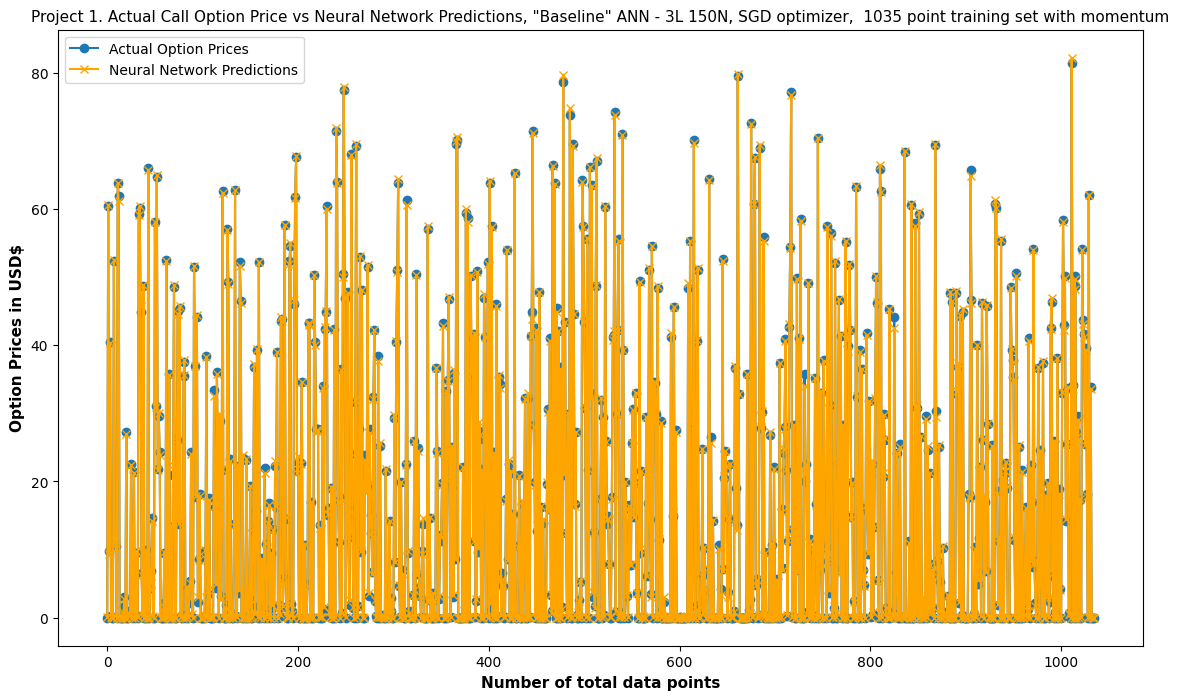

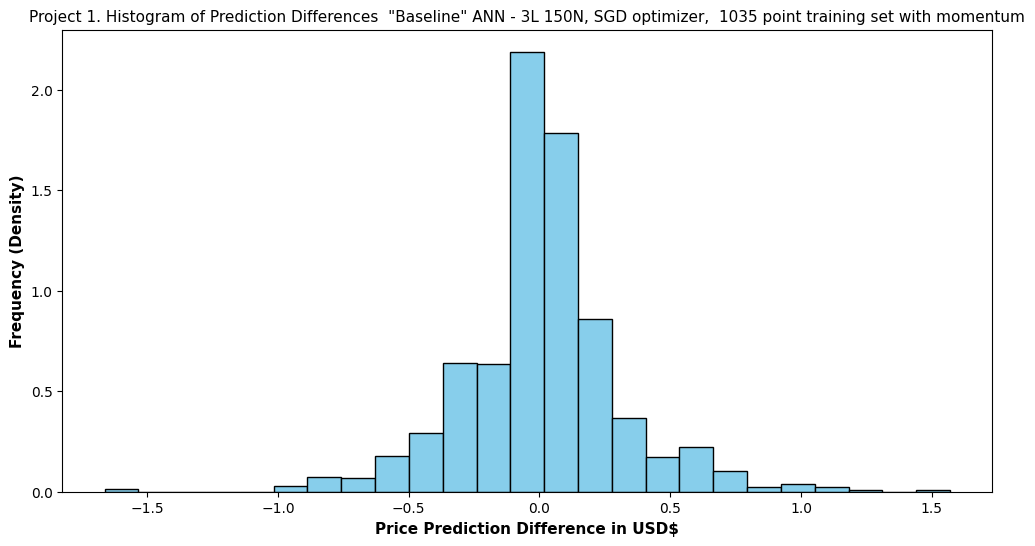

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random


# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Black-Scholes Call Price

def BlackScholes_Call_Price(Spot_Price, Strike_Price, Time_Maturity, Risk_FreeRate, Volatility):
    assert Spot_Price.shape == Strike_Price.shape == Time_Maturity.shape == Risk_FreeRate.shape == Volatility.shape
    D1 = (np.log(Spot_Price / Strike_Price) + (Risk_FreeRate + 0.5 * Volatility**2) * Time_Maturity) / (Volatility * np.sqrt(Time_Maturity))
    D2 = D1 - Volatility * np.sqrt(Time_Maturity)
    NormalD1 = norm.cdf(D1)
    NormalD2 = norm.cdf(D2)
    Call_Price = Spot_Price * NormalD1 - Strike_Price * np.exp(-Risk_FreeRate * Time_Maturity) * NormalD2
    return Call_Price, NormalD1, NormalD2


# Generate synthetic data

size_a = 1035 #used training sizes:100, 375,650,815,1035,1325,2200,3500,6500,15000
np.random.seed(42)
Spot_Price = np.random.uniform(0, 100, size=size_a)
Strike_Price = np.random.uniform(20, 80, size=size_a)
TimeMaturity = np.random.uniform(0.04, 2, size=size_a)
RiskFreeRate = np.random.uniform(0, 0.2, size=size_a)
Volatility = np.random.uniform(0, 0.35, size=size_a)




OptionPrices, _, _ = BlackScholes_Call_Price(
    Spot_Price, Strike_Price, TimeMaturity, RiskFreeRate, Volatility
)

data = pd.DataFrame({
    'Spot-Price': Spot_Price,
    'Strike-Price': Strike_Price,
    'Risk-Free-Rate': RiskFreeRate,
    'Time-to-Maturity': TimeMaturity,
    'Volatility': Volatility,
    'Call-Option-Price': OptionPrices
})


# Feature scaling (MinMax)

features = data[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
Data_Target = data['Call-Option-Price']

scaler = MinMaxScaler()
ScaledFeatures = scaler.fit_transform(features)

X_tensor = torch.tensor(ScaledFeatures, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Data_Target.values, dtype=torch.float32).view(-1, 1).to(device)


# Neural Network
class BlackScholesNN(nn.Module):
    def __init__(self, Input_Param, Hidden_Size, Num_Hidden_Layers, Output_param):
        super(BlackScholesNN, self).__init__()
        
        layers = []
        in_features = Input_Param
        
        # Build hidden layers
        for _ in range(Num_Hidden_Layers):
            layers.append(nn.Linear(in_features, Hidden_Size))
            layers.append(nn.ReLU())
            in_features = Hidden_Size
        
        # Output layer
        layers.append(nn.Linear(in_features, Output_param))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


Input_Param = X_tensor.shape[1]
Output_param = 1
Hidden_Size = 50
Num_Hidden_Layers = 3

model = BlackScholesNN(Input_Param, Hidden_Size, Num_Hidden_Layers, Output_param).to(device)

ErrorCriterion = nn.MSELoss()
MAE_Criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
Epoch_Size = 1500

# Training loop
for Ep in range(Epoch_Size):
    model.train()
    outputs = model(X_tensor)
    loss = ErrorCriterion(outputs, Y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (Ep + 1) % 100 == 0:
        print(f'Epoch [{Ep+1}/{Epoch_Size}], Loss: {loss.item():.4f}')

# Predictions
with torch.no_grad():
    model.eval()
    AllThePredictions = model(X_tensor)

# Apply deterministic non-negativity
Tailored_predictions = torch.clamp(AllThePredictions, min=0)

# Convert to NumPy
Tailored_predictions_squeezed = Tailored_predictions.cpu().numpy().squeeze()



# Combine results

Predictions_Data = pd.concat([
    data.reset_index(drop=True),
    pd.DataFrame(Tailored_predictions_squeezed, columns=['Neural Network Prediction'])
], axis=1)

Predictions_Data['Prediction-Difference'] = Predictions_Data['Neural Network Prediction'] - Predictions_Data['Call-Option-Price']
# Metrics
MeanSquaredLoss = ErrorCriterion(torch.tensor(Tailored_predictions_squeezed).view(-1,1), Y_tensor.cpu()).item()
MeanAbsLoss = MAE_Criterion(torch.tensor(Tailored_predictions_squeezed).view(-1,1), Y_tensor.cpu()).item()
MeanError = Predictions_Data['Prediction-Difference'].mean()
StdError = Predictions_Data['Prediction-Difference'].std()

print(f'MSE (Train): {MeanSquaredLoss:.4f}')
print(f'MAE (Train): {MeanAbsLoss:.4f}')
print(f'Mean Error: {MeanError:.4f}')
print(f'Std of Errors: {StdError:.4f}')

Predictions_Data['Mean Squared Error'] = MeanSquaredLoss
Predictions_Data['Mean Absolute Error'] = MeanAbsLoss
Predictions_Data['Mean Error'] = MeanError
Predictions_Data['Std of Errors'] = StdError

Predictions_Data.to_csv('./option_price_stats_expanded_SGD.csv', index=False)
Predictions_Data.to_csv('./option_price_stats_expanded_SGD.txt', index=False)

# Plots
plt.figure(figsize=(14, 8))
plt.plot(Predictions_Data.index, Predictions_Data['Call-Option-Price'], label='Actual Option Prices', marker='o')
plt.plot(Predictions_Data.index, Predictions_Data['Neural Network Prediction'], label='Neural Network Predictions', marker='x', color='orange')
plt.title('Project 1. Actual Call Option Price vs Neural Network Predictions, "Baseline" ANN - 3L 150N, SGD optimizer,  1035 point training set with momentum', fontsize=11)
plt.xlabel('Number of total data points', fontsize=11, fontweight='bold')
plt.ylabel('Option Prices in USD$', fontsize=11, fontweight='bold')
plt.legend()
plt.savefig('Option_Price_Predictions_7_Layers_700_Neurons_100_Data_Points.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(Predictions_Data['Prediction-Difference'], bins=25, color='skyblue', edgecolor='black', density=True)
plt.title('Project 1. Histogram of Prediction Differences  "Baseline" ANN - 3L 150N, SGD optimizer,  1035 point training set with momentum', fontsize=11)
plt.xlabel('Price Prediction Difference in USD$', fontsize=11, fontweight='bold')
plt.ylabel('Frequency (Density)', fontsize=11, fontweight='bold')
plt.savefig('Histogram_Prediction_Differences_7_Layers_700_Neurons_100_Data_Points.pdf', bbox_inches='tight', dpi=300)
plt.show()
